# Supervised Learning

You will now explore data coming from the american Bureau of Transportation Statistics where they recorded (a lot of) data from flights in the US from 1987 to 2008 and analysed the causes of delays. 
We will only look at data from 2008 and a subset of around 100 000 instances. We also removed some of the columns to simplify the analysis

The aim is to build a classifier that can predict whether a flight will arrive with a significant delay given the parameters at takeoff.

### Loading the data

As usual, start by loading `pandas`, `numpy`, `matplotlib` and `seaborn` and load the data corresponding to the file `flights08.csv`.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


In [2]:
data = pd.read_csv("data/flights08.csv")


### Getting a first look at the data

Have a look at the data:

* Do the attributes make sense? (see [here](http://stat-computing.org/dataexpo/2009/the-data.html) if needed)
* What's the shape of the dataset?
* How many missing values are present?
* How many unique values are present per attribute? what does that tell you? 

In [3]:
print("Shape of the data: {}\n".format(data.shape))
print("Missing values? ...\n")
print(data.apply(np.isnan).sum())

print("\nNumber of unique values?...\n")
print(data.apply(pd.Series.nunique))


Shape of the data: (99999, 18)

Missing values? ...

Month                    0
DayofMonth               0
DayOfWeek                0
DepTime               1142
CRSDepTime               0
CRSArrTime               0
CRSElapsedTime           0
ArrDelay              1302
DepDelay              1142
Distance                 0
TaxiOut               1142
Cancelled                0
Diverted                 0
CarrierDelay         80370
WeatherDelay         80370
NASDelay             80370
SecurityDelay        80370
LateAircraftDelay    80370
dtype: int64

Number of unique values?...

Month                   1
DayofMonth             31
DayOfWeek               7
DepTime              1154
CRSDepTime            213
CRSArrTime            402
CRSElapsedTime        157
ArrDelay              390
DepDelay              353
Distance              445
TaxiOut               113
Cancelled               2
Diverted                2
CarrierDelay          209
WeatherDelay          169
NASDelay              191
Se

### Dealing with missing values

The previous step should have shown you two things:

1. some features have a **lot** of missing values (in particular those associated with Delay at departure). In the sequel we will assume that a missing value for a Delay amounts to no Delay. 
2. some feature don't have enough unique values to be interesting (which ones?) and should probably removed. 

Based on this:

* fill the missing values associated with `*Delay` by a 0
* remove the feature(s) that don't have enough variability
* remove all instances that have missing values left

In [4]:
del data['Month']

for col in ['CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay']:
    data[col].fillna(0, inplace=True)

data.dropna(axis=0, inplace=True)


### Extracting the response

Our aim is to predict whether there will be a significative delay. 
The variable that encodes the delay is `ArrDelay`. 

* Start by having a look at it using `distplot` from `seaborn` 
* then compute the delay threshold such that 70% of the positive delays are lower than that threshold (note: if you're struggling to compute this, set the threshold to 26 minutes)
* form a response vector `major_delay` being either 0 or 1 depending on whether the delay is less than or greater or equal to the threshold
* finally remove the `ArrDelay` column from the dataset.

Percentage higher than threshold? 29.381046349328585pct.


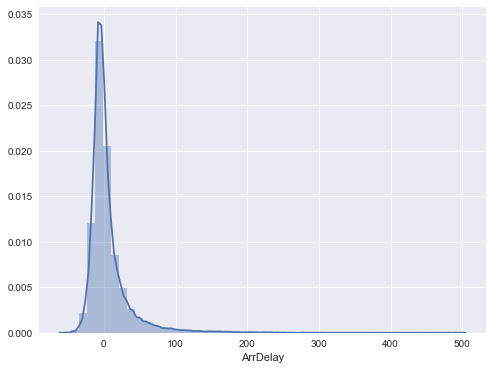

In [5]:
plt.figure(figsize=(8, 6))
sns.distplot(data['ArrDelay'])

all_delays = data['ArrDelay']
positive_delays = all_delays[all_delays > 0]
delay_threshold = np.percentile(positive_delays, 70)

# Note you can check this worked:
print("Percentage higher than threshold? {}pct.".format(
    100 * sum(positive_delays > delay_threshold) / len(positive_delays)))

major_delay = (all_delays >= delay_threshold).astype(int)

del data['ArrDelay']


### Splitting the data into a training and a testing set

Now that you have reasonably clean data, it's time to split into a training set to train your model(s) and a test set to test those! Sklearn has all that sorted for you, of course. 

Import the function `train_test_split` from `sklearn.model_selection` and check the documentation using the `?` as usual. 

In [0]:
from sklearn.model_selection import train_test_split


The key options that you are most likely to use are:

* `test_size` a proportion so a number between 0 and 1, typically `0.2` or `0.3`
* `random_state` an arbitrary integer to seed the train-test split so that your experiments are reproducible
* `stratify` in the case of imbalanced data, you want to make sure your test set and your training set contain similar proportion of the different classes. 

Create `X_train`, `X_test`, `y_train`, `y_test` out of `data` and `major_delay`, use `0.3` as proportion for test and set the random state to `5175`. Specify `major_delay` as the stratifier. 

In [0]:
X_train, X_test, y_train, y_test = train_test_split(data, major_delay, 
                                                    test_size=0.3, random_state=5175,
                                                    stratify=major_delay)


## Decision Tree Classifier (DTC)

We will apply a DTC to the dataset and see how it does.

### Using SkLearn's DTC

The procedure above can be highly optimised making the fitting of a particular DTC very fast. Much like for the kNN, SkLearn offers the `DecisionTreeClassifier` from `sklearn.tree`. Have a look at the documentation then declare a tree with no more than 3 levels. Fit it on the training data. 

In [0]:
from sklearn.tree import DecisionTreeClassifier

dtc = DecisionTreeClassifier(max_depth=3)

dtc.fit(X_train, y_train)

### (Bonus) Visualising the DTC

A nice feature is to export the tree and display it using `graphviz` (http://www.graphviz.org/Download..php) 

* on Mac: install with `Homebrew` using `brew install graphviz`
* on Windows: http://www.graphviz.org/Download_windows.php 
* on Linux: http://www.graphviz.org/Download..php

To do this, 

* import `export_graphviz` from `sklearn.tree`
* use `export_graphviz` on the tree you fitted above specifying a name for the output file like `tree.dot`
* (see also [the documentation](http://scikit-learn.org/stable/modules/generated/sklearn.tree.export_graphviz.html))

To see how it looks, use graphviz: 

```bash
dot -Tpng tree.dot -o tree.png
```

![](tree.png)


In [0]:
from sklearn.tree import export_graphviz

export_graphviz(dtc, out_file='tree.dot')


### Assessing the quality of a DTC

Using

```python
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
```

* recover the confusion matrix on the training or the test set
* recover the classification report on the training or the test set
* adjust the depth of the tree to get optimal results

(**Bonus**) if you have the time: try to explore the parameters of the DTC, what do they mean? do they help? See also [the doc](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier). 

In [0]:
y_test_pred2 = dtc.predict(X_test)

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
print("The confusion matrix: \n")
print(confusion_matrix(y_test, y_test_pred2))
print("\nThe classification report:\n")
print(classification_report(y_test, y_test_pred2, digits=3))


## Random Forest Classifier

The accuracy is already extremely high, this is because some of the features are "too informative". Let's remove a few features and re-compute a train-test set. 

In [0]:
del data["DepDelay"]
del data["TaxiOut"]
del data["Cancelled"]
del data["Diverted"]
del data["CarrierDelay"]
del data["WeatherDelay"]
del data["NASDelay"]
del data["SecurityDelay"]
del data["LateAircraftDelay"]

X_train, X_test, y_train, y_test = train_test_split(data, major_delay, 
                                                    test_size=0.3, random_state=5175,
                                                    stratify=major_delay)

Adjust a DTC again to this data, and look at the classification report, you will still get a 
fairy high score though significantly lower than the one before

In [0]:
dtc = DecisionTreeClassifier(max_depth=3)

dtc.fit(X_train, y_train)

y_test_pred2 = dtc.predict(X_test)

print("The confusion matrix: \n")
print(confusion_matrix(y_test, y_test_pred2))
print("\nThe classification report:\n")
print(classification_report(y_test, y_test_pred2, digits=3))


### Fitting a RFC

Try fitting a Random forest classifier (`RandomForestClassifier` from `sklearn.ensemble`), as a starting point, use 50 estimators. How is the accuracy now? Can you adjust the parameters further to get better results? 

In [1]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=50)

rf.fit(X_train, y_train)

y_test_pred3 = rf.predict(X_test)

print("The confusion matrix: \n")
print(confusion_matrix(y_test, y_test_pred3))
print("\nThe classification report:\n")
print(classification_report(y_test, y_test_pred3, digits=3))


NameError: name 'X_train' is not defined